# Import Library

In [ ]:
!pip install pythainlp
!pip install epitran
!pip install sklearn_crfsuite
!pip install tensorflow deepcut
!pip install attacut

In [ ]:
!wget -q https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf

In [ ]:
import matplotlib as mpl
mpl.font_manager.fontManager.addfont('thsarabunnew-webfont.ttf')
mpl.rc('font', family='TH Sarabun New')

In [ ]:
import pandas as pd
import numpy as np
import string
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
import re
import os
import io
import time
import pythainlp
from pythainlp import word_tokenize

# Read and pre-process data

In [ ]:
data_path = "/content/drive/MyDrive/NMT Hackathon/tha.txt"
#Read the data
lines_raw= pd.read_table(data_path,names=['source', 'target', 'comments'])
lines_raw = lines_raw.drop('comments',axis=1)
lines_raw.to_csv('tha.txt' , index = False , header=False , sep='\t',)
lines_raw.sample(5)

,source,target
2632,I'd like to be a millionaire.,ฉันอยากเป็นเศรษฐี
3393,Have you ever heard her sing on stage?,คุณเคยได้ยินเธอร้องเพลงบนเวทีบ้างไหม?
995,He sat on the bed.,เขานั่งบนเตียง
946,What did you say?,คุณพูดอะไร?
1236,She has no manners.,เธอไม่มีมารยาท


In [ ]:
def preprocess_sentence_eng(sentence):

    '''
    Clean and preprocess the source sentences.

    - Convert text to lower case (english_only)
    - Remove quotes
    - Clean digits from the source and target sentences. If the source or the target language use different symbols for the numbers, then remove those symbols
    - Remove spaces
    - Add a space between the word and the punctuations like “?”
    - Add “start_” tag at the start of the sentence and “_end” tag at the end of the sentence

    '''
    
    num_digits= str.maketrans('','', digits)
    
    sentence= sentence.lower()
    sentence= re.sub(" +", " ", sentence)
    sentence= re.sub("'", '', sentence)
    sentence= sentence.translate(num_digits)
    sentence= re.sub(r"([?.!,¿])", r" \1 ", sentence)
    sentence = sentence.rstrip().strip()
    sentence=  'start_ ' + sentence + ' _end'
    
    return sentence

In [ ]:
def preprocess_sentence_thai(sentence):

    '''
    Clean and preprocess the target sentences.

    - word_tokenize for thai character
    - Remove quotes
    - Clean digits from the source and target sentences. If the source or the target language use different symbols for the numbers, then remove those symbols
    - Remove spaces
    - Add a space between the word and the punctuations like “?”
    - Add “start_” tag at the start of the sentence and “_end” tag at the end of the sentence

    '''

    sentence = word_tokenize(sentence)
    sep = ' '
    sentence = sep.join(sentence)

    num_digits= str.maketrans('','', digits)
    sentence= sentence.lower()
    sentence= re.sub(" +", " ", sentence)
    sentence= re.sub("'", '', sentence) # Remove quotes
    sentence= sentence.translate(num_digits) # Clean digits
    #sentence= re.sub(r"([?.!,¿])", r" \1 ", sentence)
    sentence = sentence.rstrip().strip()
    sentence=  'start_ ' + sentence + ' _end'
    
    return sentence

In [ ]:
# Test English
text = '''Can you answer this riddle?'''
print(preprocess_sentence_eng(text))

start_ can you answer this riddle ? _end


In [ ]:
# test tokenizer
text = '''คุณเคยได้ยินเธอร้องเพลงบนเวทีบ้างไหม?'''
print("newmm    :", word_tokenize(text))  # default engine is "newmm"
print("longest  :", word_tokenize(text, engine="longest"))
print("multi_cut:", word_tokenize(text, engine="multi_cut"))
print("deepcut  :", word_tokenize(text, engine="deepcut"))
print("attacut  :", word_tokenize(text, engine="attacut"))

newmm    : ['คุณ', 'เคย', 'ได้ยิน', 'เธอ', 'ร้องเพลง', 'บน', 'เวที', 'บ้าง', 'ไหม', '?']
longest  : ['คุณ', 'เคย', 'ได้ยิน', 'เธอ', 'ร้องเพลง', 'บน', 'เวที', 'บ้าง', 'ไหม', '?']
multi_cut: ['คุณ', 'เคย', 'ได้ยิน', 'เธอ', 'ร้องเพลงบน', 'เวที', 'บ้าง', 'ไหม', '?']
deepcut  : ['คุณ', 'เคย', 'ได้ยิน', 'เธอ', 'ร้อง', 'เพลง', 'บน', 'เวที', 'บ้าง', 'ไหม', '?']
attacut  : ['คุณ', 'เคย', 'ได้ยิน', 'เธอ', 'ร้อง', 'เพลง', 'บน', 'เวที', 'บ้าง', 'ไหม', '?']


In [ ]:
# Test Thai
text = '''คุณช่วยไขปริศนานี้ได้ไหม?	'''
print(preprocess_sentence_thai(text))

start_ คุณ ช่วย ไข ปริศนา นี้ ได้ ไหม ? _end


In [ ]:
def create_dataset(path):

  '''
  Preprocessing the source and target sentences to have word pairs in the format: [ENGLISH, THAI]
  '''
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
  
  word_pairs = [[preprocess_sentence_eng(w) if index == 0  else preprocess_sentence_thai(w) for index , w in enumerate(l.split('\t'))]  for l in lines]
  
  return zip(*word_pairs)

In [ ]:
# create_dataset
data_path_pre =  '/content/tha.txt'
source, target = create_dataset(data_path_pre)

In [ ]:
print(source[:10])
print(target[:10])

('start_ hi . _end', 'start_ run . _end', 'start_ who ? _end', 'start_ wow ! _end', 'start_ fire ! _end', 'start_ help ! _end', 'start_ jump ! _end', 'start_ jump . _end', 'start_ stop ! _end', 'start_ wait . _end')
('start_ สวัสดี _end', 'start_ วิ่ง _end', 'start_ ใคร ? _end', 'start_ ว้าว ! _end', 'start_ ยิง ! _end', 'start_ ช่วยด้วย ! _end', 'start_ กระโดด ! _end', 'start_ กระโดด _end', 'start_ หยุด ! _end', 'start_ รอ ก่อน _end')


# Tokenize Source and Target

In [ ]:
# Tokenize source sentence

# Create a tokenizer for source sentence
source_sentence_tokenizer= tf.keras.preprocessing.text.Tokenizer(filters='')
# Fit the source sentences to the source tokenizer
source_sentence_tokenizer.fit_on_texts(source)
#Transforms each text in texts to a sequence of integers.
source_tensor = source_sentence_tokenizer.texts_to_sequences(source)
#Sequences that are shorter than num_timesteps, padded with 0 at the end.
source_tensor= tf.keras.preprocessing.sequence.pad_sequences(source_tensor,padding='post' )
print(source[-1])
print(source_tensor[-1])

start_ if you spend too much time in the sun without putting on sunscreen ,  you are likely to get a sunburn . _end
[   1  107    5 1132   73  124   47   17    9  891  398 1131   43 2241
   31    5   22 1081    7   77   10 2242    3    2]


In [ ]:
# Tokenize target sentence

# create the target sentence tokenizer
target_sentence_tokenizer= tf.keras.preprocessing.text.Tokenizer(filters='')
# Fit the tokenizer on target sentences
target_sentence_tokenizer.fit_on_texts(target)
#conver target text to sequnec of integers
target_tensor = target_sentence_tokenizer.texts_to_sequences(target)
# Post pad the shorter sequences with 0
target_tensor= tf.keras.preprocessing.sequence.pad_sequences(target_tensor,padding='post' )
print(target[-1])
print(target_tensor[-1])

start_ หาก คุณ ใช้เวลา อยู่ กลางแดด มากเกินไป โดย ไม่ ใส่ ครีมกันแดด คุณ มีโอกาส ถูก แดด เผา _end
[   1 2241    4  322   21 2242  215  440    6  237 2243    4 2244   87
 2245 2246    2    0    0    0    0    0    0    0    0    0    0    0
    0]


# Create training and test dataset

In [ ]:
#80% of data is used for training and 20% for testing the model
source_train_tensor, source_test_tensor, target_train_tensor, target_test_tensor= train_test_split(source_tensor, target_tensor,test_size=0.2)

In [ ]:
# Create Dataset Obejct

#setting the BATCH SIZE
BATCH_SIZE = 64
#Create data in memeory 
dataset = tf.data.Dataset.from_tensor_slices((source_train_tensor, target_train_tensor)).shuffle(BATCH_SIZE)
# shuffles the data in the batch
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
# inspect datashape
#Each batch of source data will be of the size (BATCH_SIZE, max_source_length), and a batch size of target data will be (BATCH_SIZE, max_target_length). 
for source , target in dataset.take(1): # take 1 bacth
  print(source)
  print(target)


tf.Tensor(
[[  1 645   3 ...   0   0   0]
 [  1  48  37 ...   0   0   0]
 [  1   4  52 ...   0   0   0]
 ...
 [  1   4  20 ...   0   0   0]
 [  1 107  15 ...   0   0   0]
 [  1  12   5 ...   0   0   0]], shape=(64, 24), dtype=int32)
tf.Tensor(
[[  1 279   2 ...   0   0   0]
 [  1  20   6 ...   0   0   0]
 [  1   3   6 ...   0   0   0]
 ...
 [  1  90   8 ...   0   0   0]
 [  1 120  16 ...   0   0   0]
 [  1   4 131 ...   0   0   0]], shape=(64, 29), dtype=int32)


# Model Section

In [ ]:
# Setting a few parameters for the model
BUFFER_SIZE = len(source_train_tensor)
steps_per_epoch= len(source_train_tensor)//BATCH_SIZE
embedding_dim=256
units=1024
source_vocab_size= len(source_sentence_tokenizer.word_index)+1
target_vocab_size= len(target_sentence_tokenizer.word_index)+1
print(source_vocab_size)
print(target_vocab_size)

2243
2247


# Create the Encoder

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, encoder_units, batch_size):
        super(Encoder, self).__init__()
        self.batch_size= batch_size
        self.encoder_units=  encoder_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim) # The Encoder takes the input as the source tokens, passes them to an embedding layer for the dense representation of the vector
        self.gru= tf.keras.layers.GRU(encoder_units, # no of hidden unit
                                      return_sequences=True,
                                      return_state=True,recurrent_initializer='glorot_uniform'
                                     )
    
    def call(self, x, hidden):
        #pass the input x to the embedding layer
        x= self.embedding(x)
        # pass the embedding and the hidden state to GRU
        output, state = self.gru(x, initial_state=hidden)
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_size, self.encoder_units)) # shape = ( batch size , num of hidden state)

In [ ]:
# Testing encoder

# Test example 
#Creates an Iterator for enumerating the elements of this dataset.
#Extract the next element from the dataset
source_batch, target_batch =next(iter(dataset))
print(source_batch.shape)

encoder = Encoder(source_vocab_size, embedding_dim, units, BATCH_SIZE) # declare model
sample_hidden = encoder.initialize_hidden_state() # zero initailize hidden state
sample_output, sample_hidden= encoder(source_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

(64, 24)
Encoder output shape: (batch size, sequence length, units) (64, 24, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)



# Create Bahdanau Attention layer

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # hidden shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # we are doing this to perform addition to calculate the score
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
# Test Attention
attention_layer= BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)
print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 24, 1)


# Create Decoder

In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [ ]:
# Test the decoder

decoder= Decoder(target_vocab_size, embedding_dim, units, BATCH_SIZE)
sample_decoder_output, _, _= decoder(tf.random.uniform((BATCH_SIZE,1)), sample_hidden, sample_output)
print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 2247)


# Train Step

In [ ]:
#Define the optimizer and the loss function
optimizer = tf.keras.optimizers.Adam()
# Define loss
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)
  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  return tf.reduce_mean(loss_)

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([target_sentence_tokenizer.word_index['start_']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [ ]:
checkpoint_dir = 'training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [ ]:
EPOCHS = 20

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss
    if batch % 100 == 0:
      print('Epoch {} Batch {} loss {}'.format(epoch + 1,batch, batch_loss.numpy()))
   
      
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 loss 0.9148176908493042
Epoch 1 Loss 0.9598
Time taken for 1 epoch 4.389145851135254 sec

Epoch 2 Batch 0 loss 0.8811312913894653
Epoch 2 Loss 0.9003
Time taken for 1 epoch 4.720505237579346 sec

Epoch 3 Batch 0 loss 0.8231908679008484
Epoch 3 Loss 0.8462
Time taken for 1 epoch 4.369579076766968 sec

Epoch 4 Batch 0 loss 0.7803424000740051
Epoch 4 Loss 0.7895
Time taken for 1 epoch 4.647928714752197 sec

Epoch 5 Batch 0 loss 0.6940440535545349
Epoch 5 Loss 0.7391
Time taken for 1 epoch 4.3592236042022705 sec

Epoch 6 Batch 0 loss 0.6618810296058655
Epoch 6 Loss 0.6889
Time taken for 1 epoch 4.651968002319336 sec

Epoch 7 Batch 0 loss 0.6629324555397034
Epoch 7 Loss 0.6337
Time taken for 1 epoch 4.344269037246704 sec

Epoch 8 Batch 0 loss 0.6031203269958496
Epoch 8 Loss 0.5840
Time taken for 1 epoch 4.652373552322388 sec

Epoch 9 Batch 0 loss 0.5461190342903137
Epoch 9 Loss 0.5312
Time taken for 1 epoch 4.36860203742981 sec

Epoch 10 Batch 0 loss 0.5314657688140869
Epoch

In [ ]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     multiple                  574208    
                                                                 
 gru (GRU)                   multiple                  3938304   
                                                                 
Total params: 4,512,512
Trainable params: 4,512,512
Non-trainable params: 0
_________________________________________________________________


In [ ]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     multiple                  575232    
                                                                 
 gru_1 (GRU)                 multiple                  7084032   
                                                                 
 dense_17 (Dense)            multiple                  2303175   
                                                                 
 bahdanau_attention_1 (Bahda  multiple                 2100225   
 nauAttention)                                                   
                                                                 
Total params: 12,062,664
Trainable params: 12,062,664
Non-trainable params: 0
_________________________________________________________________


# Inference

In [ ]:
#Calculating the max length of the source and target sentences
max_target_length= max(len(t) for t in  target_tensor)
max_source_length= max(len(t) for t in source_tensor)

In [ ]:
def evaluate(sentence):

  ''' 
  step:
  - Pass the source sentence,
  - Preprocess the sentence to convert to lower case, removes spaces, special characters, put a space between the word and the punctuations, etc.
  - Tokenize the sentence to create the word2index dictionary
  - Post pad the source sequence with 0 to have the same length as the max source sentence
  - Create input tensors
  - Create the Encoder and pass the input vector along with the hidden state. The initial hidden state is set to zero
  - The first input to the Decoder will be “start_” tag. The initial hidden state of the Decoder is the Encoder hidden state
  - Create the Decoder to which we pass the Decoder input, Decoder hidden state, and Encoder output
  - Store the Attention weights and using the Decoder input, hidden and Context vector, find the integer for the word with maximum probability.
  - Convert the integer to word and keep appending the predicted words to form the target sentence till we encounter the ‘end_’ tag or reach the max target sequence length
  '''



  attention_plot = np.zeros((max_target_length, max_source_length))

  sentence = preprocess_sentence_eng(sentence)
  #print(sentence)
  #print(source_sentence_tokenizer.word_index)

  inputs = [source_sentence_tokenizer.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_source_length,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))] # The initial hidden state is set to zero
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([target_sentence_tokenizer.word_index['start_']], 0)

  for t in range(max_target_length):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += target_sentence_tokenizer.index_word[predicted_id] + ' '

    if target_sentence_tokenizer.index_word[predicted_id] == '_end':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [ ]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [ ]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)
  
  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

# Final translations with Attention Plots

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint_dir = '/content/training_checkpoints'
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: start_ i love you very much . _end
Predicted translation: ฉัน รัก คุณ _end 


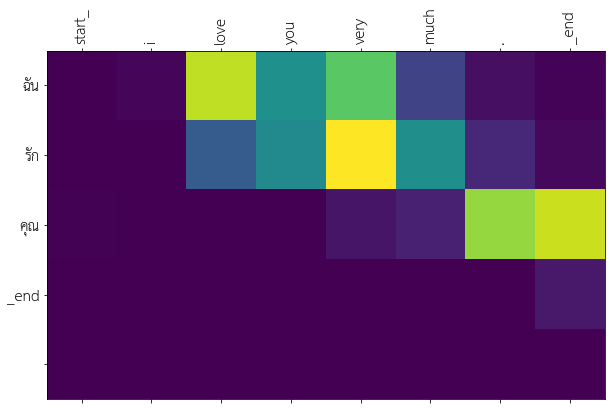

In [ ]:
translate('I love you very much.')

Input: start_ what do you want for breakfast ? _end
Predicted translation: คุณ ต้องการ อะไร ? _end 


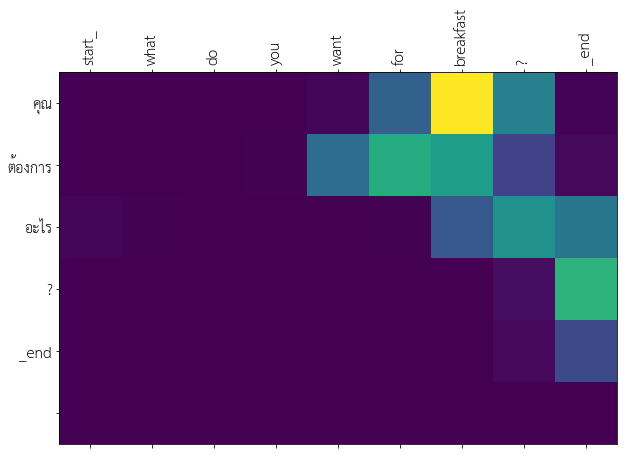

In [ ]:
translate('What do you want for breakfast?')

Input: start_ tom where you go last night ? _end
Predicted translation: คุณ ไป ที่ประชุม มั๊ย? _end 


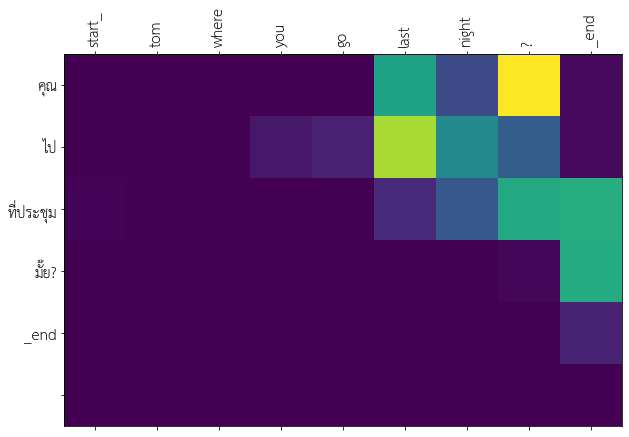

In [ ]:
translate('Tom where you go last night?')